In [1]:
%matplotlib inline
#%matplotlib notebook
import pylab
import numpy as np
import nengo
import scipy


In [2]:
class MultiplicativeNetwork(nengo.Network):
    def __init__(self, exponents, epsilon=0.001, n_neurons=200, 
                 input_dist=None,
                 output_dist=None,
                 n_samples=1000,
                 use_scaled_for_total_eval_points=True):
        super(MultiplicativeNetwork, self).__init__()
        self.exponents = np.array(exponents, dtype=float)
        self.w = self.exponents / np.sum(np.abs(self.exponents))
        self.epsilon = epsilon
        
        
        with self:
            # when connecting to this input, you must apply self.encode_func to transform the data
            self.input = nengo.Node(None, size_in=len(exponents), label='input')
            
            # this is the summed values (hidden layer 2 in the original formulation)
            self.total = nengo.Ensemble(n_neurons=n_neurons, dimensions=1)
            
            # this is the decoded value (output node in the original formulation)
            self.output = nengo.Node(None, size_in=1)
            
            # scale the inputs by w and sum them into the total population
            nengo.Connection(self.input, self.total, transform=[self.w], synapse=None)
            
            # apply the bias
            self.bias = nengo.Node([np.sum(self.w)-1], label='bias')
            nengo.Connection(self.bias, self.total, synapse=None)
            
            # decode back out to the original 0-1 range
            nengo.Connection(self.total, self.output, function=self.decode_func, 
                             synapse=None)
        
        
        if output_dist is not None:
            # just use the given output distribution, if known
            eval_points = output_dist.sample(n_samples, d=1)
        else:
            # otherwise, compute the output distribution from the input distributions
            if input_dist is None:
                input_dist = [nengo.dists.Uniform(self.epsilon, 1) for i in range(len(exponents))]
            eval_points = np.ones((n_samples,1))
            for i, exp in enumerate(self.exponents):
                input_pts = input_dist[i].sample(n_samples, d=1)
                eval_points *= input_pts**exp
                
        # the scaled version seems better in the testing I've done
        if use_scaled_for_total_eval_points:
            self.total.eval_points = self.encode_func_scaled(eval_points)
        else:
            self.total.eval_points = self.encode_func(eval_points)
                        
    # the mapping from total back to the original 0-1 range
    def decode_func(self, x):
        return self.epsilon ** (self.ialpha(x)*np.sum(np.abs(self.exponents)))
    
    # the transformation for a single input
    def encode_func(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon))
    
    # the inverse of the decode_func
    def encode_func_scaled(self, x):
        x = np.maximum(x, self.epsilon)
        return self.alpha(np.log(x)/np.log(self.epsilon)/np.sum(np.abs(self.exponents)))
        
    def alpha(self, x):
        a = self.epsilon
        b = 1
        return (x - (a+b)/2)*2/(b-a)
    def ialpha(self, x):
        a = self.epsilon
        b = 1
        return (x/2*(b-a))+(a+b)/2        


Here's a quick function for testing accuracy

In [42]:
def test(exponents, n_inputs=100, T_input=0.2, epsilon=0.001, show_plot=False, **kwargs):
    D = len(exponents)

    samples = np.random.uniform(epsilon, 1, size=(n_inputs, D))

    model = nengo.Network()
    with model:

        stim = nengo.Node(lambda t: samples[int(t / T_input) % n_inputs])
        p_stim = nengo.Probe(stim, synapse=None)

        mult = MultiplicativeNetwork(exponents, epsilon=epsilon, **kwargs)
        p = nengo.Probe(mult.output, synapse=0.03)

        nengo.Connection(stim, mult.input, function=mult.encode_func, synapse=None)
        
    sim = nengo.Simulator(model)
    sim.run(T_input*n_inputs, progress_bar=False)
    
    correct = np.ones_like(sim.trange())
    for i in range(D):
        correct *= sim.data[p_stim][:,i]**exponents[i]
    correct = nengo.synapses.filt(correct,nengo.synapses.Lowpass(0.03),  dt=sim.dt, x0=0)    

    if show_plot:
        pylab.plot(sim.trange(), sim.data[p])
        pylab.plot(sim.trange(), correct)    

    
    rmse = np.sqrt(np.mean((sim.data[p][:,0]-correct)**2))
    return rmse


You can just run it once to compute rms error

0.011999922348282639

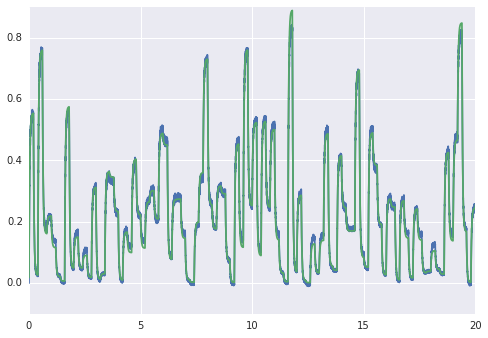

In [83]:
test(exponents=[1,1], n_neurons=100, show_plot=True)

Or run it many times and gather data

In [47]:
Ns = [10, 20, 50, 100, 200, 500, 1000]
data = {}
for N in Ns:
    data[N] = []



Run this block a few times to gather enough data

In [79]:
for i in range(10):
    print i
    for N in Ns:
        data[N].append(test(exponents=(1,1), n_neurons=N))

0
1
2
3
4
5
6
7
8
9


Now plot the data, using pandas and seaborn

In [88]:
import pandas as pd
table = []
for N, rmses in data.items():
    for rms in rmses:
        table.append((N, rms, np.log10(rms), np.log10(N)))
df = pd.DataFrame(table, columns=['n_neurons', 'error', 'log(error)', 'log(n_neurons)'])

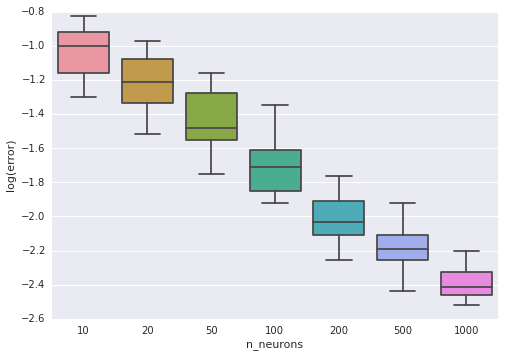

In [89]:
import seaborn as sns
ax = sns.boxplot('n_neurons', 'log(error)', data=df)


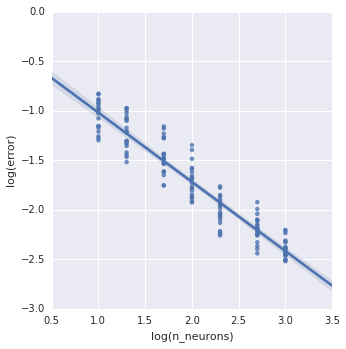

In [90]:
ax = sns.lmplot('log(n_neurons)', 'log(error)', data=df)